# **Logistic Regression Tutorial**
**Written by: Muhammad Daffa Robani, Faiz Izzaturrahman**

**Edited and maintained by: Pramudita Satria Palar, Javensius Sembiring, Edy Suwondo, Khairul Ummah, Yohanes Bimo Dwianto.**

**Last updated: 4-April-2023**


This Python notebook demonstrates and explains a logistic regression model applied to a simple two-variable problem. 

There are several existing packages for linear regression (e.g. ```sklearn```) that you can use easily. However, in this notebook, we coded logistic regression from scratch so you can see the translation of what you just learned from class into Python codes. 



The very first step is to import several packages that we will use, to be more specific:


*   ```numpy``` for supporting multi-dimensional matrices.
*   ```pandas``` for importing the CSV data (although pandas has more capabilities!)
*   ```scipy```, specifically we will use the statistic package from scipy.
*   ```statsmodels```, for more statistics related functions
*   ```matplotlib``` for plotting the data.
*   ```mpl_toolkits``` for 3D plotting.

Please start by executing the cell below:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats import weightstats as stests
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
from mpl_toolkits.mplot3d import Axes3D
import io


# Importing and Organizing The Data + Preliminary analysis




The very first step that you need to do is to upload the data into your local cloud folder. To that end, we will use ```drive.mount()``` from ```google.colab```. For this tutorial, we will use the ```univ_score.csv```. However, you can actually use any CSV/TXT data! The first columns of your CSV should consist of the matrix of observation (your data set $\boldsymbol{X}$): 

$\boldsymbol{X} = \begin{bmatrix} x_{11} & x_{12} & \ldots & x_{1p}\\
x_{21} & x_{22} & \ldots & x_{2p} \\
\vdots & \vdots & \vdots & \vdots \\
 x_{n1} & x_{n2} & \ldots & x_{np}\end{bmatrix}$

where $n$ is the number of samples and $p$ is the number of input variables / features. The last column of your CSV should consists of the output $\boldsymbol{y}$:

$\boldsymbol{y} = ( y_{1},y_{2},\ldots,y_{n})^{T}$
Notice that the label $\boldsymbol{y}$ is categorical for classification problem.

Let's execute the following cell to mount your Google Drive folder:


In [2]:
#from google.colab import files
#Import the data (in .csv file)
#uploaded = files.upload()

# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
#Read the data using panda module, data that will be modelled is saved as a variable called data
data = pd.read_csv('data/univ_score.csv',index_col='Unnamed: 0')
# data = pd.read_csv('gdrive/My Drive/Colab Notebooks/AE2204 SDS - old/data/univ_score.csv',index_col='Unnamed: 0') # You need to change this if the name of your csv file changes (the first column is the number of observation and we skip that)

#Reformat the data as numpy array, to make it consistent with other following type of variables. This variable is saved as data_array.
data_array = data.to_numpy()
n_entries = data_array.shape[0] #Count the number of data entries
n_var = data_array.shape[1]-1 #Count the number of features (variables/predictors)
print("Five first rows of the data: ")
print(data_array[:5])

Five first rows of the data: 
[[34.62365962 78.02469282  0.        ]
 [30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]]


In [4]:
#Split the data into X and y
X = data.iloc[:,0:n_var].to_numpy() #Take X from the data
y = data.iloc[:,-1].to_numpy() #Take y from the data
print("Five first rows of X: ")
print(X[:5])
print("Five first rows of y: ")
print(y[:5].reshape(-1,1))

Five first rows of X: 
[[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]]
Five first rows of y: 
[[0]
 [0]
 [0]
 [1]
 [1]]


## **Pearson Correlation Coefficient (r)**
One useful technique to check the correlation between variables is to use Pearson correlation coefficient. You learned the basic from class, so you know that positive $r$ means that both variables change in the same direction (and the opposite for negative $r$). Here is the equation for your reminder.

$r = \frac{\sum{(X_1 - \mu_{X_1})(X_2 - \mu_{X_2})}}{\sqrt{\sum{(X_1 - \mu_{X_1})^2}\sum{(X_2 - \mu_{X_2})^2}}}$

The Pearson Correlation Coefficient calculates the linear relationship between two datasets $X_1$ and $X_2$ with their respective mean values $\mu_{X_1}$ and $\mu_{X_2}$ . The coefficient, **r**, takes on values between -1 and +1. Whereby the sign of the value indicates negative or positive correlation and the magnitude determines how linear the correlation is. 

We will make a correlation matrix because you have two input and one output variables. For that, we will call ```stats.pearsonr``` to calculate the correlation

In [5]:
#Function to create correlation matrix
def correlmat(data):
    n_var = data.shape[1]-1
    correl = np.zeros((n_var+1,n_var+1))
    for i in range(n_var+1):
        for j in range(n_var+1):
            correl[i,j],_ = stats.pearsonr(data[:,i],data[:,j]) #Calculate pearson's correlation coefficient
    return correl

Based on the data we have, we compute the correlation matrix by calling the ``` correlmat ``` function 



In [6]:
#Call correlmat function to obtain the correlation matrix
correl_matrix = correlmat(data_array)
print("Correlation Matrix: ")
print(correl_matrix)

Correlation Matrix: 
[[ 1.         -0.02366459  0.57405657]
 [-0.02366459  1.          0.51232333]
 [ 0.57405657  0.51232333  1.        ]]


Here we would like to create a function in which we can visualize our samples. As opposed to a regression where our outputs are continuous values, the task of classification refers to their outputs as **labels**. In this scenario we have 2 labels i.e. **2 classes of data, 0-class (y=0) and 1-class (y=1)**.
Since our $X$ data has two features, we would expect a 2D plot.

First, we split our $X$ array based on their labels $y$. To do so we would first extract the indices of $y$, where $y=1$ and similarly where $y=0$. These indices are stored in the variables ``` pos ``` and ``` neg ``` respectively.
In a single figure, we generate two scatter plots from then on. Each corresponds to their labels. As you shall see different colors will denote each class.

In [7]:
#@title Visualizing the data with scatter plot
#This procedure can only be conducted with 1/2 number of features only
#Function to create the scatter plot
def datascatterplot(X,y):
    pos = np.where(y==1) #To find rows that have y=1
    neg = np.where(y==0) #To find rows that have y=0
    n_var = X.shape[1]
    if n_var==1: #Procedure for one variable
        fig = plt.figure(figsize=[8,6])
        plt.scatter(X[pos],y[pos])
        plt.scatter(X[neg],y[neg])
        plt.xlabel('x',fontsize=14)
        plt.ylabel('y',fontsize=14)
        plt.show()
    elif n_var==2: #Procedure for two variables
        fig = plt.figure(figsize=[8,6])
        plt.scatter(X[pos,0],X[pos,1],label='y=1')
        plt.scatter(X[neg,0],X[neg,1],label='y=0')
        plt.xlabel('x1',fontsize=14)
        plt.ylabel('x2',fontsize=14)
        plt.title('Scatter Plot of The Samples',fontsize=16)
        plt.legend()
        plt.show()
    else:
        print("Your data has more than two variables")

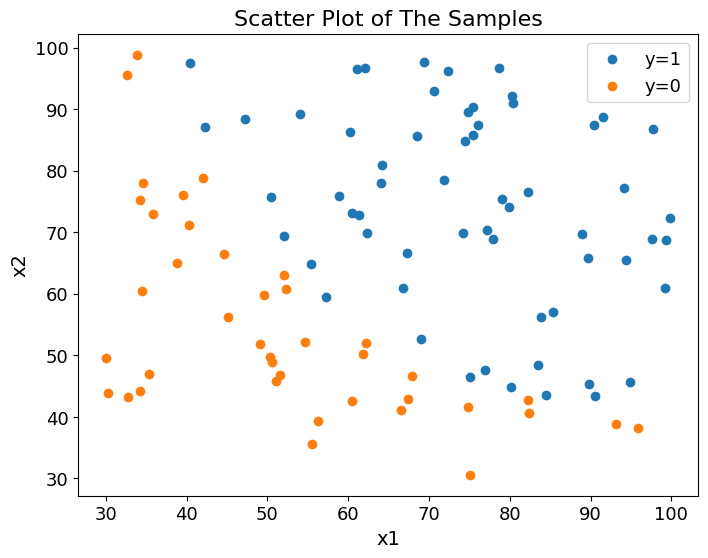

In [8]:
#To create the visualization, call datascatterplot_log
datascatterplot(X,y)

# Creating a Logistic Regression Model




### Concept

As opposed to Linear Regression, whose aim was to generate a model that could predict outputs whose values are continuous, we would like to create a classification model with discrete predictions, e.g. 0 or 1. Normally, the task of predicting which class a point belongs to is deemed a **classification task**. However, with Logistic Regression, we would like to *model the **probability** that a specific output $Y$ belongs to a particular class/category*. In the present scenario, our data consists of samples that belong to either one of two classes, $Y=0$ or  $Y=1$. The specific task that handles data with two classes is called a **binary classification**.

With logistic regression, we create a regression model whose predictions represent a probability. Previously with linear regression, the model took the form of $Y = \beta X$ where $Y$. The logistic regression model takes the form of a logistic/sigmoid function which restricts the values of the outputs to fall in the range of $0-L$, where $L$ is some arbitrary value reflective of the outputs $Y$, usually the maximum, i.e. if $Y \in [0, 1]$ then $L=1$, so that we can interpret is a probability. A *threshold* at $L/2$ is usually set to denote whether a particular sample is an instance of the *default* class if its probability is above this threshold. This is convenient since the task is to classify our samples according to their classes, represented by a discrete value, but would also provide us with some form of *uncertainty* in our predictions.

For example, let the samples $X$ whose $Y=1$ denote the *default* class $C1$, as opposed to the class $C0$ where $Y=0$. Given a test sample $x$, if the model predicts its probability $p(x)$ as above $1/2$ then we are *certain* that $x \in C1$, otherwise if it is less than $1/2$ then $x \in C0$

Furthermore, since this is a regression model, we would have to *train* the model by finding the best coefficients, $\beta$, to represent the model. Like with linear regression, these coefficients are multiplied with the samples $X$.

From here on, we can now move on to the details


 

### **Logistic/Sigmoid Function**

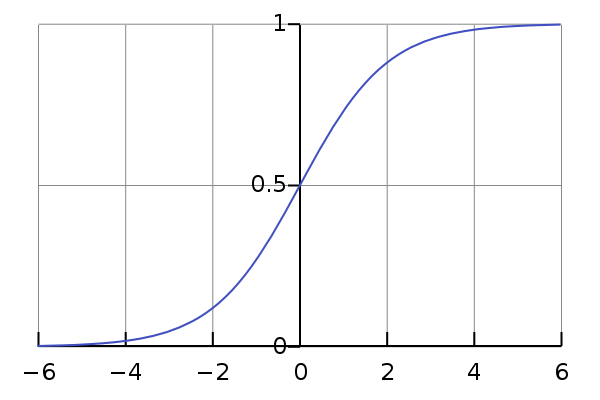

Logistic regression models the probability of a default class, say for the samples $X$ whose $Y=1$. Previously, we mentioned that the model takes the form of a logistic/sigmoid function. The general formula is written as,
$$p(X)=  \frac{L}{1+e^{-(\beta X)} }$$
However, since we would like to model to predict values between 0-1, we set $L=1$ and automatically $p(X)$ will be a fraction of 1 and positive since the denominator is restricted by the negative exponential, i.e. $e^{-9999} = 0$. This is written in the following ``` sigmoid ``` function (please execute this cell):



In [9]:
#Function to call sigmoid based on scores
def sigmoid(scores):
    return 1/(1+np.exp(-scores))

### **Model Prediction**
Just before we get into the training procedure, we look as to how the model makes predictions. In the ```predict``` function, we first **concatenate** our $X$ data with a vector of ones to get an array $F$. As with linear regression, this is simply representative of the *intercept* i.e. $\beta_0$. Thus, the variable ```y_pred``` is $p(X)$ and  ``` scores ``` represents $F\beta$ to which the predictions at new test points is simply the evaluation of the ```sigmoid``` function with $F\beta$:

In [10]:
#Function to calculate scores and/or prediction given by a logistic regression model
def predict(X,beta):
  #Create F matrix
  F = np.ones((X.shape[0],X.shape[1]+1))
  F[:,1:] = X
  #Calculate prediction
  scores = F@beta
  y_pred = sigmoid(scores)
  return scores, y_pred

### **Training the Model**
To train the logistic regression model we use the **maximum likelihood principle**. The principle is essentially to **maximize the likelihood function**. The likelihood function, is **a function that measures the goodness of fit between a model and the given (training) data**. The parameters that control the model is of course $\beta$. Thus, the likelihood is a function of $\beta$ and for the default class $C1$ is written as,

$$ L(\beta) = \prod_{x \in C1}{p(x)} \prod_{x' \in C0}{(1-p(x'))} $$

For reasons outside the scope of this course, we shall instead consider maximizing the **log likelihood function** which is mathematically equivalent but just written differently for ease of computation. For a total of $N$ samples in the data array $X$, this is written as, 

$$ \text{log}(L(\beta)) = \sum_{i=1}^{N} (y_i \beta x_i - \text{log}(1+e^{\beta x_i}))$$

This function is written in ```log_likelihood_cal ```:


In [11]:
#Function to calculate log likelihood
def log_likelihood_cal(X,y,beta):
    #Calculate scores at every value of X
    scores, _ = predict(X, beta)
    log_likelihood = np.sum(y*scores-np.log(1+np.exp(scores))) #Calculate log likelihood
    return log_likelihood

Recall your days of multivariable calculus, specifically the topic of **finding optima** in functions. That is, the problem of **finding stationary points** (zero first derivatives). Computationally, this is done through an iterative procedure. The specific algorithm to be used in the present work is the **Newton-Raphson algorithm**.


Since we are trying to find stationary points in the log-likelihood function then we would need the first derivative.

$$ \frac{\partial L(\beta)}{\partial \beta} = \sum_{i=1}^{N} F_i (y_i - p(x_i, \beta))$$

(Recall that $F$ is simply $F = [1^T X]$ and $p$ is the evaluation of the ```sigmoid``` function with the current $F\beta$ values.)

Furthermore, with the **Newton-Raphson algorithm** we would require the second-derivative/Hessian matrix.
$$ \frac{\partial^2 L(\beta)}{\partial \beta \partial \beta^T} = \sum_{i=1}^{N} -F_i F_i^{T}p(x_i, \beta) (1 - p(x_i, \beta))$$

Please execute the cell below to create the ```log_likelihood_der_cal``` subroutine that we will need to find the best logistic regression model:


In [12]:
#Function to call the derivative of log likelihood calculation
def log_likelihood_der_cal(X,y,beta):
    #Create F matrix
    F = np.ones((X.shape[0],X.shape[1]+1))
    F[:,1:] = X
    #Calculate scores
    scores,_ = predict(X, beta)
    #Calculate the first derivatives
    dl = np.sum(F*(y-sigmoid(scores)).reshape(-1,1),axis=0) #First derivatives

    #Calculate the second derivatives
    temp = np.ones((F.shape[1],F.shape[1],F.shape[0]))
    for i in range(X.shape[0]):
        temp[:,:,i] = np.multiply(F[i,:].reshape(-1,1)@F[i,:].reshape(-1,1).T,-1*sigmoid(scores[i])*(1-sigmoid(scores[i])))
    dl2 = np.sum(temp,axis=2) #Second derivatives
    return dl,dl2

The process of maximizing the log-likelihood, would go as follows:

**Initialization:**

1. Set initial $\beta_0$ to, say, all zeros. ($\beta^{old}=\beta_0$)
2. Set an initial log-likelihood to zero $(LL^{old})$, and compute another log-likelihood $(LL^{now})$ based on $\beta_0$ 
3. Set a tolerance value, say $1\times 10^{-6}$ , which shall form the stopping criteria as $ if \quad (|LL^{now} - LL^{old}| < 1\times 10^{-6}) \rightarrow stop$

**Main Procedure**

$while \quad |LL^{now} - LL^{old}| > 1\times 10^{-6}$
1. Compute $\beta^{now} = \beta^{old} - \Big(\frac{\partial^2 L(\beta)}{\partial \beta \partial \beta^T}\Big)^{-1}\Big(\frac{\partial L(\beta)}{\partial \beta}\Big)$
2. Set $LL^{old} = LL^{now}$
3. Recompute $LL^{now}$ based on $\beta^{now}$
3. Recompute $\frac{\partial^2 L(\beta)}{\partial \beta \partial \beta^T}$ and $\frac{\partial L(\beta)}{\partial \beta}$

The cell below contains the subroutine that we will use to to find the best logistic regression parameter:

In [13]:
#Function to create a logistic regression model on the data. The model is obtained by conducting procedure to maximize log likelihood.
def logistic_regression_train(X,y):
    #Initial values for the model coefficients. (All set to zeros)
    beta = np.zeros((X.shape[1]+1))
    
    likelihood_old = 0
    likelihood_now = log_likelihood_cal(X,y,beta) #Log likelihood value of the initial model
    [dl,dl2] = log_likelihood_der_cal(X,y,beta) #Log likelihood derivatives of the initial model 
    it = 0
    tol = 1e-20 #Tolerance value to stop iteration
    while np.abs(likelihood_now-likelihood_old) > tol:
        it = it+1
        beta = beta-np.linalg.inv(dl2)@dl #New model coefficients, based on a gradient descent optimization scheme.
        likelihood_old = np.copy(likelihood_now) #Log likelihood value of the previous model.
        likelihood_now = log_likelihood_cal(X,y,beta) #Log likelihood value of the current model.
        [dl,dl2] = log_likelihood_der_cal(X,y,beta) #Log likelihood derivatives of the current model
        print("Iteration: {}, Likelihood:{}".format(it,likelihood_now))
        
    se = np.sqrt(np.diag(np.linalg.inv(-dl2))) #Calculate standard deviation of each model coefficient 
    return beta,likelihood_now, se

The following cell train your logistic regression model based on the given $X$ and $y$. The procedure automatically stops when it finds the optimum parameters:

In [14]:
#To obtain a logistic regression model on your data, call logistic_regression_train
[beta,likelihood,beta_se] = logistic_regression_train(X,y)

# Print the coefficients
print("The coefficients of your logistic regression model are as follows:")
for i in range(0,n_var+1):
    print('beta_{} = {:.4f}'.format(i,beta[i]))

Iteration: 1, Likelihood:-33.14730142682167
Iteration: 2, Likelihood:-24.786698154860446
Iteration: 3, Likelihood:-21.387046748583835
Iteration: 4, Likelihood:-20.446861067416243
Iteration: 5, Likelihood:-20.35108040369588
Iteration: 6, Likelihood:-20.34977045143185
Iteration: 7, Likelihood:-20.34977015894402
Iteration: 8, Likelihood:-20.349770158944004
Iteration: 9, Likelihood:-20.349770158944
Iteration: 10, Likelihood:-20.349770158944
The coefficients of your logistic regression model are as follows:
beta_0 = -25.1613
beta_1 = 0.2062
beta_2 = 0.2015


# 3. Evaluating and Interpreting The Model




After you build your logistic regression model, now you want to assess its performance and accuracy. To that end, you would need the model parameter statistics that summarize important values. Here we create a summary for the model parameter statistics:




In [15]:
#Function to create summary matrix
def summarymat_log(beta, beta_se):
    n_var = beta.shape[0]-1
    summary = np.zeros((n_var+1,5))
    summary[:,0] = beta #Model coefficients. 
    summary[:,1] = beta_se #Standard deviation of each model coefficient. 
    summary[:,2] = np.divide(summary[:,0],summary[:,1]) #Z-statistic.
    summary[:,3] = stats.norm.sf(np.abs(summary[:,2]))*2 #Calculate p-value based on z-statistic.
    #Hypothesis test with 95% confidence interval
    for i in range(n_var+1):
        if summary[i,3]<= 0.05: #If p<=0.05, null hypothesis is denied
            summary[i,4] = 1
        else:
            summary[i,4] = 0 #If p<=0.05, null hypothesis is accepted
    return summary

In [16]:
#To create summary matrix of the trained model, call summarymat_log function
summary = summarymat_log(beta, beta_se)
print("Summary matrix: ")
print(pd.DataFrame(summary,columns=['Beta','Standard Deviation', 'z-statistic', 'p-value', 'Hypothesis Test']))

Summary matrix: 
        Beta  Standard Deviation  z-statistic   p-value  Hypothesis Test
0 -25.161334            5.798552    -4.339244  0.000014              1.0
1   0.206232            0.048001     4.296436  0.000017              1.0
2   0.201472            0.048625     4.143371  0.000034              1.0


As with linear regression previously, we can compute the $R^{2}$ score to see how accurate our regression model is applicable on continuous outputs. However, since our outputs will ultimately be categorical, we consider a *pseudo* $R^{2}$ metric.

In [17]:
def pseudo_r2_comp(y_true,y_pred):
    pos = np.where(y_true==1) #To determine which rows with y=1
    neg = np.where(y_true==0) #To determine which rows with y=0
    #Calculate odds
    odds = pos[0].shape[0]/neg[0].shape[0]
    #Procedure to calculate pseudo TSS
    p_odds = odds/(1+odds)
    pseudo_tss = np.sum(y_true*np.log(p_odds)+(1-y_true)*np.log(1-p_odds))
    #Procedure to calculate pseudo R2
    #Calculate scores
    scores = np.log(y_pred/(1-y_pred))
    log_likelihood = np.sum(y_true*scores-np.log(1+np.exp(scores))) #Calculate log likelihood
    pseudo_R2 = (pseudo_tss-likelihood)/pseudo_tss
    return pseudo_R2

In [18]:
#To obtain pseudo R2 error, call pseudo_R2_comp function
_, y_pred = predict(X, beta)
pseudo_R2 = pseudo_r2_comp(y,y_pred)
print("Pseudo R2 error: {}".format(pseudo_R2))

Pseudo R2 error: 0.6976312424214763


Use the following cell to predict the probability of an input belonging to class 1 at any location:

In [19]:
_, y_pred = predict(np.array([[80,60],[20, 20],[50, 50]]), beta)
print(y_pred)

[9.68492024e-01 4.10996047e-08 8.35779372e-03]


Here we visualize the results of our model with predictions made along a $X$ space. Previously our ```predict``` function gave us the probabilities of an output, however, since the aim here is to classify samples we introduce the extra steps of including the *threshold* as previously mentioned. That is included in the snippet from the code below,

``` python
_,Z = predict(np.c_[xx.ravel(), yy.ravel()], beta)
cond_list = [Z<0.5,Z>=0.5] 
choice_list = [0, 1] # Introduce a list of variables in which our predictions can take, that is 0 or 1
Z = np.select(cond_list,choice_list) # 
```
where ```cond_list``` seperates the predicted samples Z corresponding to their probabilities and we introduce a variable```choice_list``` where the values in the list correspond to the condition in ```cond_list```.

The values in the ```Z``` array is then changed accordingly.

$Z<0.5 \rightarrow Z=0$ 

$Z>0.5 \rightarrow Z=1$

In [20]:
#@title Visualizing logistic regression model

#Function to visualize logistic regression model
def modelplot(beta,X,y):
    if X.shape[1]==1: #Procedure for data with one variable
        #Create the location of X to visualize
        X_plot = np.linspace(X.min()-0.1,X.max()+0.1,51)
        #Calculates prediction at prediction locations
        F = np.ones((51,2))
        F[:,1] = X_plot
        _, y_pred = predict(X, beta)

        fig = plt.figure(figsize=[8,6])
        plt.scatter(X,y,label='Samples')
        plt.plot(X_plot,y_pred,color='black',label='Logistic Regression Model')
        plt.title('Logistic Regression Model on The Samples',fontsize=16)
        plt.xlabel('x',fontsize=14)
        plt.ylabel('y',fontsize=14)
        plt.legend()
        plt.show
    elif X.shape[1] == 2: #Procedure for data with two variables
        
        #Create the location of X to visualize
        x_min, x_max = X[:,0].min()-0.1, X[:,0].max()+0.1
        y_min, y_max = X[:,1].min()-0.1, X[:,1].max()+0.1
        h = .25
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        #Calculate prediction at each prediction location
        _,Z = predict(np.c_[xx.ravel(), yy.ravel()], beta)
        cond_list = [Z<0.5,Z>=0.5]
        choice_list = [0, 1]
        Z = np.select(cond_list,choice_list)

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure(1, figsize=(8, 6))
        plt.set_cmap(plt.cm.Paired)
        plt.pcolormesh(xx, yy, Z)
        pos = np.where(y==1) #To find which row(s) that have y=1
        neg = np.where(y==0) #To find which row(s) that have y=0
        plt.scatter(X[pos,0],X[pos,1],label='y=1',c='tab:brown',edgecolors='k')
        plt.scatter(X[neg,0],X[neg,1],label='y=0',c='tab:cyan',edgecolors='k')
        plt.xlabel('x1', fontsize=14)
        plt.ylabel('x2', fontsize=14)
        plt.title('Logistic Regression Model on The Samples',fontsize=16)
        plt.legend(fontsize=14)
        plt.show()
        
    else:
        print("Your data has more than two variables")

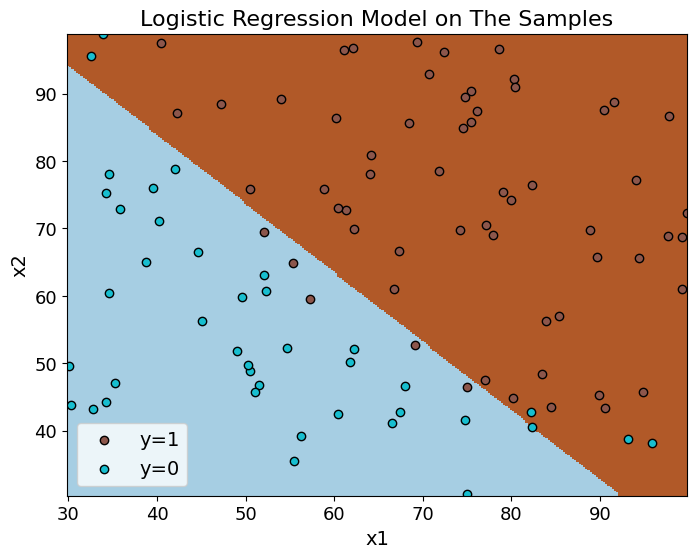

In [21]:
#To visualize the logistic regression model, call modelplot function
modelplot(beta,X,y)

# K-Nearest Neighbor Classification Model


To clarify the concept of a **parametric model**, it is a model in which the **number of parameters are fixed**, implying that the model can only take on a single form/function. For example, a **linear regression** model takes on the form:

\begin{equation}
\hat{y} = \hat{\beta_0} + \sum_{i=1}^{p} \hat{\beta_p} X_{p}
\end{equation}

This means that **no matter what your data looks like, your model will always produce a linear function to model the data.** 

Likewise, with logistic regression it takes on the form,

$$p(X)=  \frac{L}{1+e^{-(\beta X)} }$$

Due to the $\beta X$ term in the exponent, this yields the logistic regression model as a **linear classifier**. Meaning, with any data is given to the model, it will always produce a linear line that separates the different classes specified in the data.  **Note: This linear line is called a hyperplane in the context of classification**.

Parametric models are useful given we know the nature of the data, e.g. linear, polynomial, etc. However, what if the data in which no prior information about its nature is known? This is where **non-parametric** models '*enters the chat*'. With non-parametric models, the number of parameters is not fixed. In that way, a non-parametric model can take on different forms, reflective of the data. In this course, we introduce the simplest non-parametric model, that is, the **KNN-classifier**.

We will use the KNN-classifier from the popular machine learning package, i.e., ```sklearn```. Notice that the program can handle multidimensional and multi classes data. Thus, although we demonstrate its working principle on two-variable and two-classes data, you can use it for more complex problems!

Let us begin by executing the cell below (if the data is either one- or two-dimensional, the code will also plot your data):




In [22]:
#@title Visualization of KNN classification
from sklearn import neighbors #Import sklearn
from sklearn import preprocessing

def modelplotKNN(knn,X,y):
  if X.shape[1]==1: #Procedure for data with one variable
        #Create the location of X to visualize
        X_plot = np.linspace(X.min()-0.1,X.max()+0.1,51)
        #Calculate prediction at each prediction location
        y_plot = knn.predict(X_plot)

        #Create plot
        fig = plt.figure(figsize=[8,6])
        plt.scatter(X,y,label='Samples')
        plt.plot(X_plot,y_plot,color='black',label='Logistic Regression Model')
        plt.title('Logistic Regression Model on The Samples',fontsize=16)
        plt.xlabel('x',fontsize=14)
        plt.ylabel('y',fontsize=14)
        plt.legend()
        plt.show()
  elif X.shape[1] == 2: #Procedure for data with two variables
        #Create the location of X to visualize
        x_min, x_max = X[:,0].min()-0.1, X[:,0].max()+0.1
        y_min, y_max = X[:,0].min()+0.1, X[:,1].max()+0.1
        
        hx = (x_max-x_min)/250
        hy = (y_max-y_min)/250
        #Calculate prediction at each prediction location
        xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))
        X_norm = np.c_[xx.ravel(), yy.ravel()]
        #Scale X for KNN model
        scaler_X = min_max_scaler.fit(X)
        X_norm = scaler_X.transform(X_norm)
        Z = knn.predict(X_norm)

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure(1, figsize=(8, 6))
        plt.set_cmap(plt.cm.Paired)
        plt.pcolormesh(xx, yy, Z)
        pos = np.where(y==1) #To find which row(s) that have y=1
        neg = np.where(y==0) #To find which row(s) that have y=0
        plt.scatter(X[pos,0],X[pos,1],label='y=1',c='tab:brown',edgecolors='k')
        plt.scatter(X[neg,0],X[neg,1],label='y=0',c='tab:cyan',edgecolors='k')
        plt.xlabel('x1', fontsize=14)
        plt.ylabel('x2', fontsize=14)
        plt.title('Logistic Regression Model on The Samples',fontsize=16)
        plt.legend(fontsize=14)
        plt.show()
  else:
        print("Your data has more than two variables")

Are you done? Now let's create a KNN-classifier prediction by varying the $k$ (i.e., number of neighbors) value. You can do just that by changing the value of ```n_neighbors``` (which is essentially $k$) below and then run the cell:

In [23]:
#Define the number of neighbors for kNN classification
n_neighbors = 10
#Initiate min_max_scaler
min_max_scaler = preprocessing.MinMaxScaler()
#Scale X using min_max_scaler
X_norm = min_max_scaler.fit_transform(X)
#Initiate kNN classification model
knn = neighbors.KNeighborsClassifier(n_neighbors)
#Train kNN classification model on the data
knn.fit(X_norm,y)

KNeighborsClassifier(n_neighbors=10)

Now let's visualize the resulting KNN prediction on your data set (**this works only for one- or two-dimensional problem with two classes**):

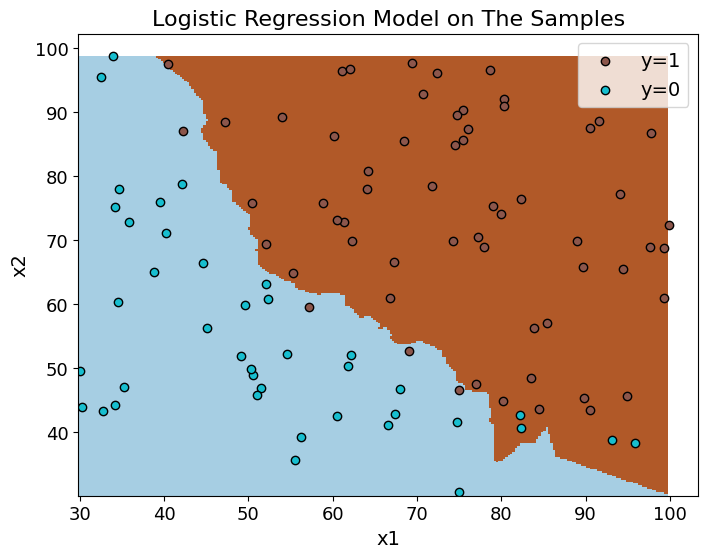

In [24]:
#Visualize the kNN classification model
modelplotKNN(knn, X, y)

Finally, you can make predictions anywhere. Look at the following cell to see one example:

In [25]:
X_pred = np.array([[60,40],[60,70]]) # prediction sites, test at x = [60,40], and x = [60, 70]
X_pred_norm = min_max_scaler.transform(X_pred) # Normalize to 0-1
y_pred_knn = knn.predict(X_pred_norm) # Predict

print(y_pred_knn) # Print the result

[0 1]


As you can see, unlike the Logistic Regression hyperplane, the KNN hyperplane is non linear, and the one in the above image may also not be the best hyperplane, implying that there are other configurations in which the model can take. This is how a non-parametric model would behave.